#**Capsule Networks tutorial on MNIST with PyTorch**

**Author**: Riccardo Renzulli, PhD student, Computer Science Department, University of Turin, Italy

**Email**: riccardo.renzulli@unito.it

<img src="https://github.com/EIDOSlab/eidos-education/blob/master/capsule-networks/assets/capsnet_architecture.png?raw=true"/>

Reference paper: [Dynamic Routing Between Capsules](https://arxiv.org/pdf/1710.09829.pdf)

A **capsule** is a subset of neurons in a layer.

Each capsule represents the presence and the instantiation parameters of an **entity**.

A capsule consists of two association parameters:

1.   the **probability** that an object of that type is present
2.   the generalized **pose** (position, orientation, scale, deformation, velocity, color etc.).

Image source: https://cezannec.github.io/assets/capsules/capsule_output.gif

<img src="https://cezannec.github.io/assets/capsules/capsule_output.gif" width="70%"/>


The **routing algorithm** is performed between PrimaryCaps and DigitCaps layers.

<img src="https://cezannec.github.io/assets/capsules/dynamic_routing.gif" width="70%"/>

Image source: https://cezannec.github.io/assets/capsules/dynamic_routing.gif

In this notebook we're going to:

1.   train a minimal Capsule Network (CapsNet-M) with just 1 capsule types and capsules dimensions (2,4)
2.   show the reconstructions of CapsNet-M
3.   show how perturbating the digit capsules of CapsNet-M affects the reconstructions
4.   load a full Capsule Network (CapsNet-F) model with 32 capsule types and capsule dimensions (8,16)
5.   show the reconstructions of CapsNet-F
6.   show how perturbating the digit capsules of CapsNet-F affects the reconstructions
7.   test CapsNet-M and of CapsNet-F on affine transformations


Have fun! 😀


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
!git clone https://github.com/EIDOSlab/eidos-education.git
import sys
import os

sys.path.append('/content/eidos-education/capsule-networks')
os.chdir('/content/eidos-education/capsule-networks/src')

import torch
import logging
import json
import argparse
import copy
import torch.nn.functional as F
import matplotlib
import pandas as pd
import numpy as np
import ops.utils as utils
import matplotlib.pyplot as plt
import loss.capsule_loss as cl
from matplotlib import gridspec
from os.path import dirname, abspath
from dataloaders.load_data import get_dataloader
from models.vectorCapsNet import VectorCapsNet
from ops.utils import save_args
from train import train
from test import test
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

fatal: destination path 'eidos-education' already exists and is not an empty directory.


#Step 1: train a minimal Capsule Network (CapsNet-M) with just 1 capsule types and capsules dimensions (2,4)

<font color='red'>**Load configuration file**</font>

In [ ]:
CONFIG_FILE = "configs/mnist.json"
config = utils.DotDict(json.load(open(CONFIG_FILE)))

<font color='red'>**Define the capsules hyperparameters in order to build a minimal Capsule Network**</font>

In [ ]:
config.seed = 0
config.batch_size = 128
config.patience = 10
config.lr = 1e-3
config.min_lr = config.lr #No scheduler
config.num_routing_iterations = 3
config.dim_primaryCaps = [2, 1]
config.dim_classCaps = [4, 1]
config.num_primaryCaps_types = 1

<font color='red'>**Set experiment folder, device and dataloaders for MNIST**</font>


In [ ]:
experiment_folder = utils.create_experiment_folder(config, config.seed)

utils.set_seed(config.seed)

test_base_dir = "../results/" + config.dataset + "/" + config.model + "/" + experiment_folder

logdir = test_base_dir + "/logs/"
checkpointsdir = test_base_dir + "/checkpoints/"
runsdir = test_base_dir + "/runs/"
imgdir = test_base_dir + "/images/"

# Make model checkpoint directory
if not os.path.exists(checkpointsdir):
    os.makedirs(checkpointsdir)

# Make log directory
if not os.path.exists(logdir):
    os.makedirs(logdir)

# Make img directory
if not os.path.exists(imgdir):
    os.makedirs(imgdir)

# Set logger path
utils.set_logger(os.path.join(logdir, "model.log"))

# Get dataset loaders
train_loader, valid_loader, test_loader = get_dataloader(config)

# Enable GPU usage
if config.use_cuda and torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

<font color='red'>**Show some images from MNIST**</font>

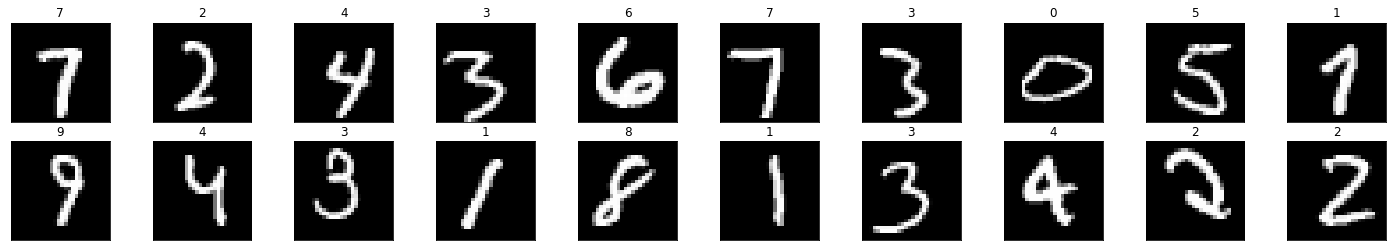

In [ ]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
batch_size = 20
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

<font color='red'>**Train CapsNet-M for 10 epochs**</font>


In [ ]:
caps_model_m = VectorCapsNet(config, device)

utils.summary(caps_model_m, config)

caps_criterion = cl.CapsLoss(config.caps_loss,
                              config.margin_loss_lambda,
                              config.reconstruction_loss_lambda,
                              config.batch_averaged,
                              config.reconstruction is not None,
                              config.m_plus,
                              config.m_minus,
                              config.m_min,
                              config.m_max,
                              device)

if config.optimizer == "adam":
    caps_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, caps_model_m.parameters()), lr=config.lr)
else:
    caps_optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, caps_model_m.parameters()), lr=config.lr)
caps_scheduler = torch.optim.lr_scheduler.ExponentialLR(caps_optimizer, config.decay_rate)

caps_model_m.to(device)
best_model_wts = copy.deepcopy(caps_model_m.state_dict())

for state in caps_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

# Print the model architecture and parameters
utils.summary(caps_model_m, config)

# Save current settings (hyperparameters etc.)
save_args(config, test_base_dir)

# Assume that we are on a CUDA machine, then this should print a CUDA device:
logging.info("Device: {}".format(device))

logging.info("Initial learning rate: {:.4f}".format(caps_scheduler.get_last_lr()[0]))
logging.info("Number of routing iterations: {}".format(config.num_routing_iterations))

best_loss = float('inf')

epoch = 0
best_epoch = 0
while epoch <= 10:
    # Start training
    logging.info("Number of routing iterations: {}".format(caps_model_m.classCaps.num_iterations))
    train(logging, config, train_loader, caps_model_m, caps_criterion, caps_optimizer, caps_scheduler, None, epoch, device)

    # Start validation
    val_loss, val_acc = test(logging, config, valid_loader, caps_model_m, caps_criterion, None, epoch, device,
                      imgdir, split="validation")
    # Start testing
    test_loss, test_acc = test(logging, config, test_loader, caps_model_m, caps_criterion, None, epoch, device, imgdir, split="test")

    formatted_epoch = str(epoch).zfill(len(str(config.epochs - 1)))
    checkpoint_filename = "epoch_{}".format(formatted_epoch)

    if val_loss < best_loss:
        utils.save_checkpoint({
            "epoch": epoch,
            "routing_iterations": caps_model_m.classCaps.num_iterations,
            "state_dict": caps_model_m.state_dict(),
            "metric": config.monitor,
            "optimizer": caps_optimizer.state_dict(),
            "scheduler": caps_scheduler.state_dict(),
        }, True, checkpointsdir, checkpoint_filename)
        best_epoch = epoch
        best_loss = val_loss
        best_model_wts = copy.deepcopy(caps_model_m.state_dict())

    # Save current epoch checkpoint
    utils.save_checkpoint({
        "epoch": epoch,
        "routing_iterations": caps_model_m.classCaps.num_iterations,
        "state_dict": caps_model_m.state_dict(),
        "metric": config.monitor,
        "optimizer": caps_optimizer.state_dict(),
        "scheduler": caps_scheduler.state_dict(),
    }, False, checkpointsdir, checkpoint_filename, config.dataset=="mnist" and config.reconstruction=="None" and config.seed==42)
    epoch += 1

Model architectures: 
VectorCapsNet(
  (conv1): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  (primaryCaps): CapsPrimary2d(
    (caps_poses): Conv2d(256, 2, kernel_size=(9, 9), stride=(2, 2))
  )
  (classCaps): CapsClass2d()
  (decoder): FCDecoder(
    (fc1): Linear(in_features=40, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=1024, bias=True)
    (fc3): Linear(in_features=1024, out_features=784, bias=True)
  )
)
Sizes of parameters: 
conv1.weight: [256, 1, 9, 9]
conv1.bias: [256]
primaryCaps.caps_poses.weight: [2, 256, 9, 9]
primaryCaps.caps_poses.bias: [2]
classCaps.weight: [1, 6, 6, 10, 4, 2]
classCaps.routing_bias: [10, 1, 1, 4, 1]
decoder.fc1.weight: [512, 40]
decoder.fc1.bias: [512]
decoder.fc2.weight: [1024, 512]
decoder.fc2.bias: [1024]
decoder.fc3.weight: [784, 1024]
decoder.fc3.bias: [784]
----------------------------------------------------------------
Total params: 1461370 
Trainable params: 1415290 
Non-trainable params (coupling coeffi

# Step 2: show the reconstructions of CapsNet-M

<font color='red'>**Load weights of the model that achieved the lowest loss on the validation set**</font>

In [ ]:
caps_model_m.load_state_dict(best_model_wts)

<All keys matched successfully>

<font color='red'>**Get the predictions and the reconstructions for CapsNet-M**</font>

In [ ]:
config.batch_size = 20

_, _, test_loader = get_dataloader(config)

caps_model_m.eval()

# First batch of images
dataiter = iter(test_loader)
dataiter.next()
images, labels = dataiter.next()

# Transform to one-hot indices: [batch_size, config.num_classes]
target = F.one_hot(labels, config.num_classes)

# Use GPU if available
images, target = images.to(device), labels.to(device)

# Get class caps and reconstructions
class_caps_poses, class_caps_activations, _, reconstructions = caps_model_m(images)
reconstructions = reconstructions.view(-1, images.size(1), images.size(2), images.size(3))

# Get predictions
norms = torch.sqrt(torch.sum(class_caps_poses ** 2, dim=2))
# pred: [batch_size,]
pred = norms.max(1, keepdim=True)[1].type(torch.LongTensor).view(config.batch_size)

# Print labels and predictions
lab = torch.cat((labels, pred), 0)
lab = lab.view(2, config.batch_size)

<font color='red'>**Show original images vs reconstructions**</font>

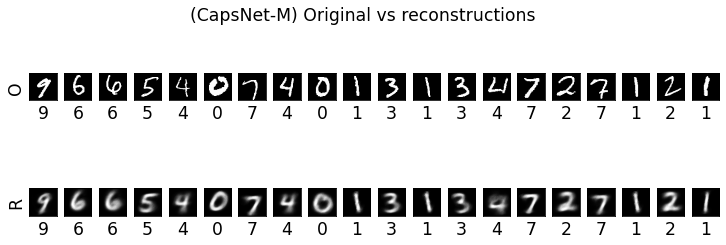

In [ ]:
# Show original images vs reconstructions
fig, axs = plt.subplots(2, config.batch_size, figsize=(10, 4))
fig.suptitle("(CapsNet-M) Original vs reconstructions", fontsize="xx-large")
axs[0, 0].set_ylabel("O", fontsize="xx-large")
axs[1, 0].set_ylabel("R", fontsize="xx-large")

np_images = images.squeeze().cpu().detach().numpy()
np_reconstructions = reconstructions.squeeze().cpu().detach().numpy()

data = [np_images, np_reconstructions]

for i in range(2):
    for j in range(config.batch_size):
        axs[i, j].imshow(data[i][j], cmap=config.cmap)
        axs[i, j].set_yticks([])
        axs[i, j].set_xticks([])
        axs[i, j].set_xlabel(str(lab[i, j].item()), fontsize="xx-large")
plt.tight_layout(pad=0.4)
plt.show()

#Step 3: show how perturbating the digit capsules of CapsNet-M affects the reconstructions

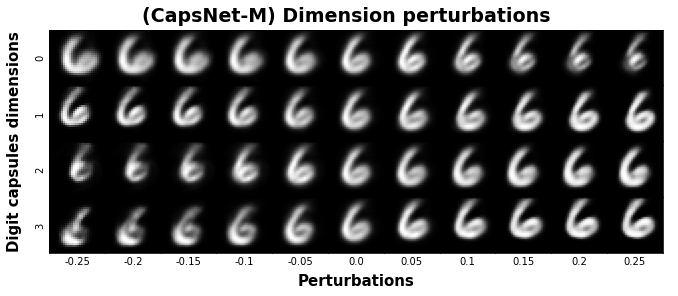

In [ ]:
# Show what the individual dimensions of a capsule represent
class_caps_shape = class_caps_poses.size(-2), class_caps_poses.size(-1)
index = 1 #8, 14, -1
example_caps = class_caps_poses[index].unsqueeze(0) # example_caps: [1, 10, 16]
label_caps = target[index] # label_caps: [1, 10]
activations = class_caps_activations[index, :].view(-1, config.num_classes)
perturb_reconstructions = []
perturb_range = np.linspace(start=-0.25, stop=0.25, num=11)

nrow = class_caps_shape[0] * class_caps_shape[1]
ncol = perturb_range.size
for dim in range(nrow):
    for perturb in perturb_range:
        example_caps_perturbed = example_caps.clone()
        example_caps_perturbed[:, :, dim] += perturb
        perturb_rec = caps_model_m.decoder(example_caps_perturbed, activations)
        perturb_rec = perturb_rec.view(images.size(1), images.size(2), images.size(3))
        perturb_rec = perturb_rec.squeeze()
        perturb_reconstructions.append(perturb_rec.squeeze())
fig = plt.figure(figsize=(ncol, nrow))


gs = gridspec.GridSpec(nrow, ncol, width_ratios=np.ones(ncol),hspace=0,wspace=0)
perturb_reconstructions_stacked = torch.stack(perturb_reconstructions, dim=0)
perturb_reconstructions_stacked = perturb_reconstructions_stacked.view(nrow, ncol, perturb_reconstructions_stacked.size(1),  perturb_reconstructions_stacked.size(2))
for i in range(nrow):
    for j in range(ncol):
        ax = plt.subplot(gs[i, j])
        np_perturb_rec = perturb_reconstructions_stacked[i,j].cpu().detach().numpy()

        ax.imshow(np_perturb_rec, cmap=config.cmap)
        ax.set_yticks([])
        ax.set_xticks([])
        if j == 0:
          ax.set_ylabel(i)
        ax.set_xlabel(round(perturb_range[j], 3))
        ax.set_aspect('equal')

gs.update(wspace=0.0, hspace=0.0) # set the spacing between axes.
fig.subplots_adjust(top=0.9) 
fig.add_subplot(1, 1, 1, frame_on=False)
# Hiding the axis ticks and tick labels of the bigger plot
plt.tick_params(labelcolor="none", bottom=False, left=False)
fig.suptitle("(CapsNet-M) Dimension perturbations", fontsize=19, fontweight='bold') 
plt.xlabel('Perturbations', fontsize=15, fontweight='bold')
plt.ylabel('Digit capsules dimensions', fontsize=15, fontweight='bold')
plt.show()

#Step 4: load a full Capsule Network (CapsNet-F) model with 32 capsule types and capsule dimensions (8,16)

In [ ]:
config_file = "../checkpoints/params.json"
config_f = utils.DotDict(json.load(open(config_file)))

checkpoint_file = "../checkpoints/model_best.pt"
if os.path.isfile(checkpoint_file):
    logging.info("Loading checkpoint '{}'".format(checkpoint_file))
    checkpoint = torch.load(checkpoint_file, map_location=device)
    config_f.num_routing_iterations = checkpoint["routing_iterations"]
    config_f.epoch = str(checkpoint["epoch"])
    config_f.batch_size = 20
    caps_model_f = VectorCapsNet(config_f, device)
    caps_model_f.load_state_dict(checkpoint["state_dict"])
    logging.info("Loaded checkpoint '{}'".format(checkpoint_file))
else:
    raise Exception("No checkpoint found at '{}'".format(checkpoint_file))

caps_model_f.to(device)
caps_model_f.eval()

# Print the model architecture and parameters
utils.summary(caps_model_f, config_f)
logging.info("Number of routing iterations:'{}'".format(config_f.num_routing_iterations))

# Assume that we are on a CUDA machine, then this should print a CUDA device:
logging.info("Device: {}".format(device))

# First batch of images
dataiter = iter(test_loader)
dataiter.next()
images, labels = dataiter.next()

# Transform to one-hot indices: [batch_size, config.num_classes]
target = F.one_hot(labels, config_f.num_classes)

# Use GPU if available
images, target = images.to(device), labels.to(device)

# Get class caps and reconstructions
class_caps_poses, class_caps_activations, _, reconstructions = caps_model_f(images)
reconstructions = reconstructions.view(-1, images.size(1), images.size(2), images.size(3))

# Get predictions
norms = torch.sqrt(torch.sum(class_caps_poses ** 2, dim=2))
# pred: [batch_size,]
pred = norms.max(1, keepdim=True)[1].type(torch.LongTensor).view(config_f.batch_size)

# Print labels and predictions
lab = torch.cat((labels, pred), 0)
lab = lab.view(2, config_f.batch_size)

Loading checkpoint '../results/mnist/VectorCapsNet/capsnet/42/checkpoints/model_best_epoch_155.pt'
Loaded checkpoint '../results/mnist/VectorCapsNet/capsnet/42/checkpoints/model_best_epoch_155.pt'
Model architectures: 
VectorCapsNet(
  (conv1): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  (primaryCaps): CapsPrimary2d(
    (caps_poses): Conv2d(256, 256, kernel_size=(9, 9), stride=(2, 2))
  )
  (classCaps): CapsClass2d()
  (decoder): FCDecoder(
    (fc1): Linear(in_features=160, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=1024, bias=True)
    (fc3): Linear(in_features=1024, out_features=784, bias=True)
  )
)
Sizes of parameters: 
conv1.weight: [256, 1, 9, 9]
conv1.bias: [256]
primaryCaps.caps_poses.weight: [256, 256, 9, 9]
primaryCaps.caps_poses.bias: [256]
classCaps.weight: [32, 6, 6, 10, 16, 8]
classCaps.routing_bias: [10, 1, 1, 16, 1]
decoder.fc1.weight: [512, 160]
decoder.fc1.bias: [512]
decoder.fc2.weight: [1024, 512]
decoder.fc2.bias: [1024]


# Step 5: show the reconstructions of CapsNet-F

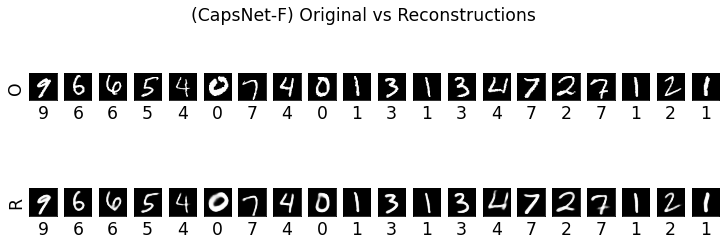

In [ ]:
# Show original images vs reconstructions
fig, axs = plt.subplots(2, config.batch_size, figsize=(10, 4))
fig.suptitle("(CapsNet-F) Original vs Reconstructions", fontsize="xx-large")
axs[0, 0].set_ylabel("O", fontsize="xx-large")
axs[1, 0].set_ylabel("R", fontsize="xx-large")

np_images = images.squeeze().cpu().detach().numpy()
np_reconstructions = reconstructions.squeeze().cpu().detach().numpy()

data = [np_images, np_reconstructions]

for i in range(2):
    for j in range(config_f.batch_size):
        axs[i, j].imshow(data[i][j], cmap=config_f.cmap)
        axs[i, j].set_yticks([])
        axs[i, j].set_xticks([])
        axs[i, j].set_xlabel(str(lab[i, j].item()), fontsize="xx-large")
plt.tight_layout(pad=0.4)
plt.show()

# Step 6: show how perturbating the digit capsules of CapsNet-F affects the reconstructions

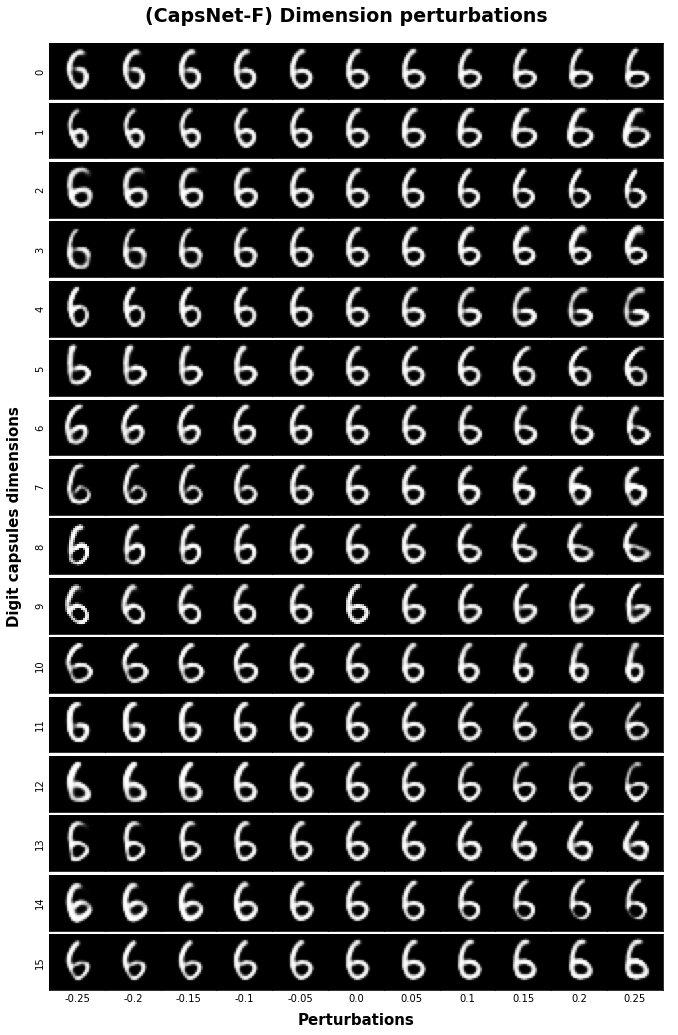

In [ ]:
# Show what the individual dimensions of a capsule represent
class_caps_shape = class_caps_poses.size(-2), class_caps_poses.size(-1)
index = 1 
example_caps = class_caps_poses[index].unsqueeze(0) # example_caps: [1, 10, 16]
label_caps = target[index] # label_caps: [1, 10]
activations = class_caps_activations[index, :].view(-1, config_f.num_classes)
perturb_reconstructions = []
perturb_range = np.linspace(start=-0.25, stop=0.25, num=11)

nrow = class_caps_shape[0] * class_caps_shape[1]
ncol = perturb_range.size
for dim in range(nrow):
    for perturb in perturb_range:
        example_caps_perturbed = example_caps.clone()
        example_caps_perturbed[:, :, dim] += perturb
        perturb_rec = caps_model_f.decoder(example_caps_perturbed, activations)
        perturb_rec = perturb_rec.view(images.size(1), images.size(2), images.size(3))
        perturb_rec = perturb_rec.squeeze()
        perturb_reconstructions.append(perturb_rec.squeeze())

fig = plt.figure(figsize=(ncol, nrow))

gs = gridspec.GridSpec(nrow, ncol, width_ratios=np.ones(ncol),hspace=0,wspace=0)
perturb_reconstructions_stacked = torch.stack(perturb_reconstructions, dim=0)
perturb_reconstructions_stacked = perturb_reconstructions_stacked.view(nrow, ncol, perturb_reconstructions_stacked.size(1),  perturb_reconstructions_stacked.size(2))
for i in range(nrow):
    for j in range(ncol):
        ax = plt.subplot(gs[i, j])
        np_perturb_rec = perturb_reconstructions_stacked[i,j].cpu().detach().numpy()

        ax.imshow(np_perturb_rec, cmap=config_f.cmap)
        ax.set_yticks([])
        ax.set_xticks([])
        if j == 0:
          ax.set_ylabel(i)
        ax.set_xlabel(round(perturb_range[j], 3))
        ax.set_aspect('equal')

gs.update(wspace=0.0, hspace=0.0) # set the spacing between axes.
fig.subplots_adjust(top=0.95) 
fig.add_subplot(1, 1, 1, frame_on=False)
# Hiding the axis ticks and tick labels of the bigger plot
plt.tick_params(labelcolor="none", bottom=False, left=False)
fig.suptitle("(CapsNet-F) Dimension perturbations", fontsize=19, fontweight='bold') 
plt.xlabel('Perturbations', fontsize=15, fontweight='bold')
plt.ylabel('Digit capsules dimensions', fontsize=15, fontweight='bold')
plt.show()

#Step 7: test CapsNet-M and of CapsNet-F on affine transformations

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

test_transform = transforms.Compose([
    transforms.RandomAffine(degrees=40, translate=(0.2,0.2), scale=(0.8, 0.8)),
    transforms.ToTensor(),
    transforms.Normalize(config_f.mean, config_f.std)
])

test_dataset_affine = datasets.MNIST(root="../data/raw/mnist",
                              train=False,
                              transform=test_transform)
test_loader_affine = DataLoader(dataset=test_dataset_affine,
                          batch_size=config.batch_size,
                          shuffle=False,
                          num_workers=config.num_workers,
                          pin_memory=config.pin_memory,
                          worker_init_fn=lambda id: utils.set_seed(42))

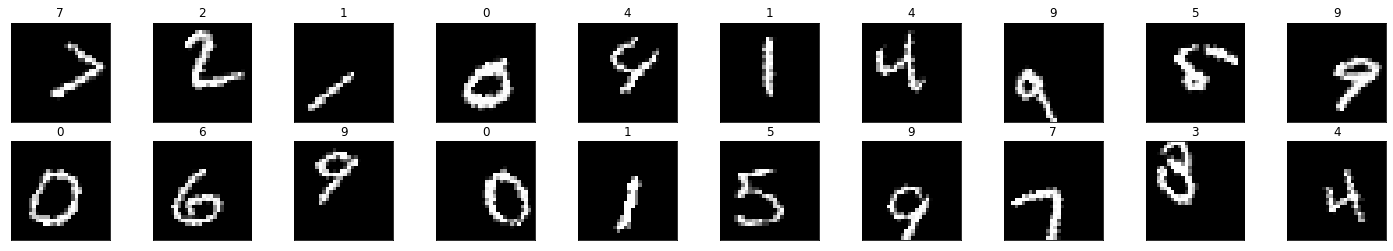

In [ ]:
# obtain one batch of training images
dataiter = iter(test_loader_affine)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
batch_size = config_f.batch_size
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

In [ ]:
test(logging, config, test_loader_affine, caps_model_m, caps_criterion, None, epoch, device, imgdir, split="test")

-------------------------------------- Testing epoch 11 --------------------------------------
100%|██████████| 500/500 [00:11<00:00, 44.84it/s]

Epoch 11 takes 11 seconds for test.
test classification report:
Class: 0 Recall: 0.3350 Precision: 0.3331 F1-Score: 0.3062
Class: 1 Recall: 0.4311 Precision: 0.5731 F1-Score: 0.4634
Class: 2 Recall: 0.4361 Precision: 0.3631 F1-Score: 0.3625
Class: 3 Recall: 0.5151 Precision: 0.3831 F1-Score: 0.4077
Class: 4 Recall: 0.3644 Precision: 0.3968 F1-Score: 0.3523
Class: 5 Recall: 0.4222 Precision: 0.2997 F1-Score: 0.3240
Class: 6 Recall: 0.2827 Precision: 0.3676 F1-Score: 0.2936
Class: 7 Recall: 0.3475 Precision: 0.3530 F1-Score: 0.3231
Class: 8 Recall: 0.3078 Precision: 0.3827 F1-Score: 0.3132
Class: 9 Recall: 0.3342 Precision: 0.3271 F1-Score: 0.3035
[[347  27  62  37  64 139  85  13  41 165]
 [ 61 539 134  82 107  61   1  89  49  12]
 [ 22   7 490 198  51  81   6 115  17  45]
 [ 14   9 175 566  25 102   3  92   6  18]
 [130  22 121  39 402  47  3

(0.6974361448287963, 0.4204)

In [ ]:
test(logging, config_f, test_loader_affine, caps_model_f, caps_criterion, None, epoch, device, imgdir, split="test")

-------------------------------------- Testing epoch 11 --------------------------------------
100%|██████████| 500/500 [00:17<00:00, 28.64it/s]

Epoch 11 takes 17 seconds for test.
test classification report:
Class: 0 Recall: 0.6547 Precision: 0.7730 F1-Score: 0.6907
Class: 1 Recall: 0.8562 Precision: 0.8215 F1-Score: 0.8243
Class: 2 Recall: 0.7819 Precision: 0.5406 F1-Score: 0.6113
Class: 3 Recall: 0.7648 Precision: 0.7990 F1-Score: 0.7646
Class: 4 Recall: 0.5946 Precision: 0.7175 F1-Score: 0.6238
Class: 5 Recall: 0.7305 Precision: 0.6431 F1-Score: 0.6595
Class: 6 Recall: 0.6318 Precision: 0.6655 F1-Score: 0.6212
Class: 7 Recall: 0.6283 Precision: 0.6622 F1-Score: 0.6175
Class: 8 Recall: 0.6934 Precision: 0.7800 F1-Score: 0.7130
Class: 9 Recall: 0.6631 Precision: 0.6852 F1-Score: 0.6491
[[ 714    2   53    6    1   13   82   10    8   91]
 [   2 1060   21    1    0   26    3   21    0    1]
 [   2   10  887   31    5   16    3   68    4    6]
 [   6    2   73  850    2   47    4   24

(0.28764400681853297, 0.7825)